In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

# Load the data
df = pd.read_csv('delhiaqi.csv')

# Convert date column to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Display basic info
print("Data Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nDescriptive Statistics:")
print(df.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 561 entries, 2023-01-01 00:00:00 to 2023-01-24 08:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co      561 non-null    float64
 1   no      561 non-null    float64
 2   no2     561 non-null    float64
 3   o3      561 non-null    float64
 4   so2     561 non-null    float64
 5   pm2_5   561 non-null    float64
 6   pm10    561 non-null    float64
 7   nh3     561 non-null    float64
dtypes: float64(8)
memory usage: 39.4 KB
None

First 5 rows:
                          co     no    no2    o3    so2   pm2_5    pm10    nh3
date                                                                          
2023-01-01 00:00:00  1655.58   1.66  39.41  5.90  17.88  169.29  194.64   5.83
2023-01-01 01:00:00  1869.20   6.82  42.16  1.99  22.17  182.84  211.08   7.66
2023-01-01 02:00:00  2510.07  27.72  43.87  0.02  30.04  220.25  260.68  11.40
2023-01-01 03:00:00  3

In [2]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Handle missing values (if any) - using forward fill for time series
df.fillna(method='ffill', inplace=True)

# Add derived columns
df['pm_ratio'] = df['pm2_5'] / df['pm10']  # Ratio of PM2.5 to PM10
df['total_pollution'] = df[['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']].sum(axis=1)

# Extract time-based features
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Display cleaned data info
print("\nCleaned Data Info:")
print(df.info())

Missing values per column:
co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 561 entries, 2023-01-01 00:00:00 to 2023-01-24 08:00:00
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   co               561 non-null    float64
 1   no               561 non-null    float64
 2   no2              561 non-null    float64
 3   o3               561 non-null    float64
 4   so2              561 non-null    float64
 5   pm2_5            561 non-null    float64
 6   pm10             561 non-null    float64
 7   nh3              561 non-null    float64
 8   pm_ratio         561 non-null    float64
 9   total_pollution  561 non-null    float64
 10  hour             561 non-null    int32  
 11  day              561 non-null    int32  
 12  month            561 non-null    int32  
 13  year           

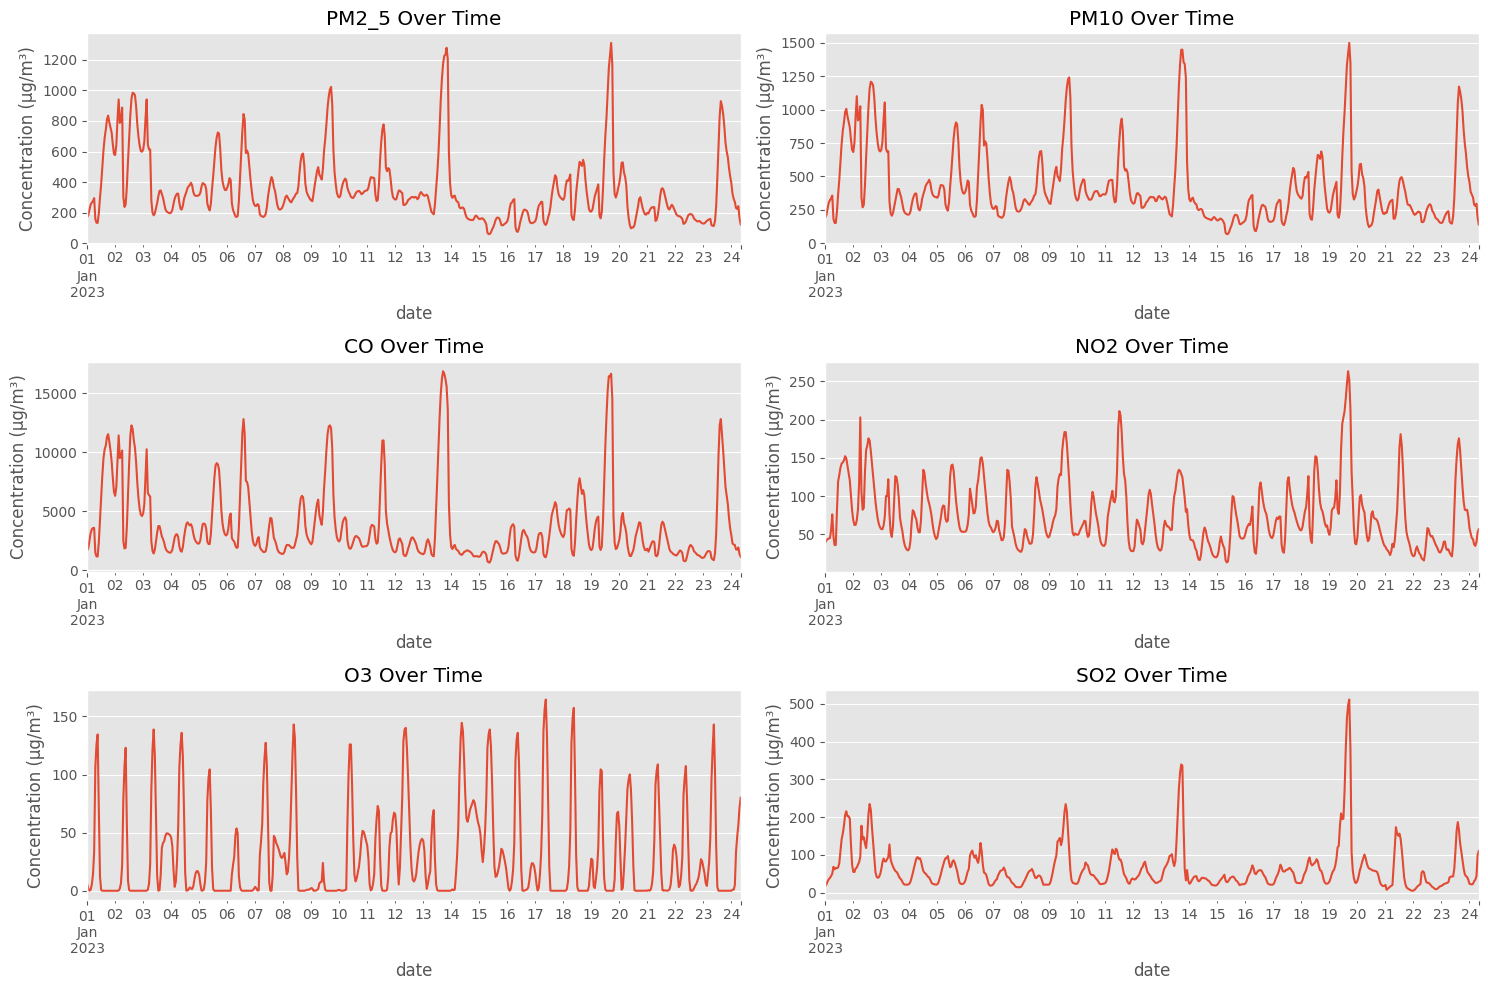

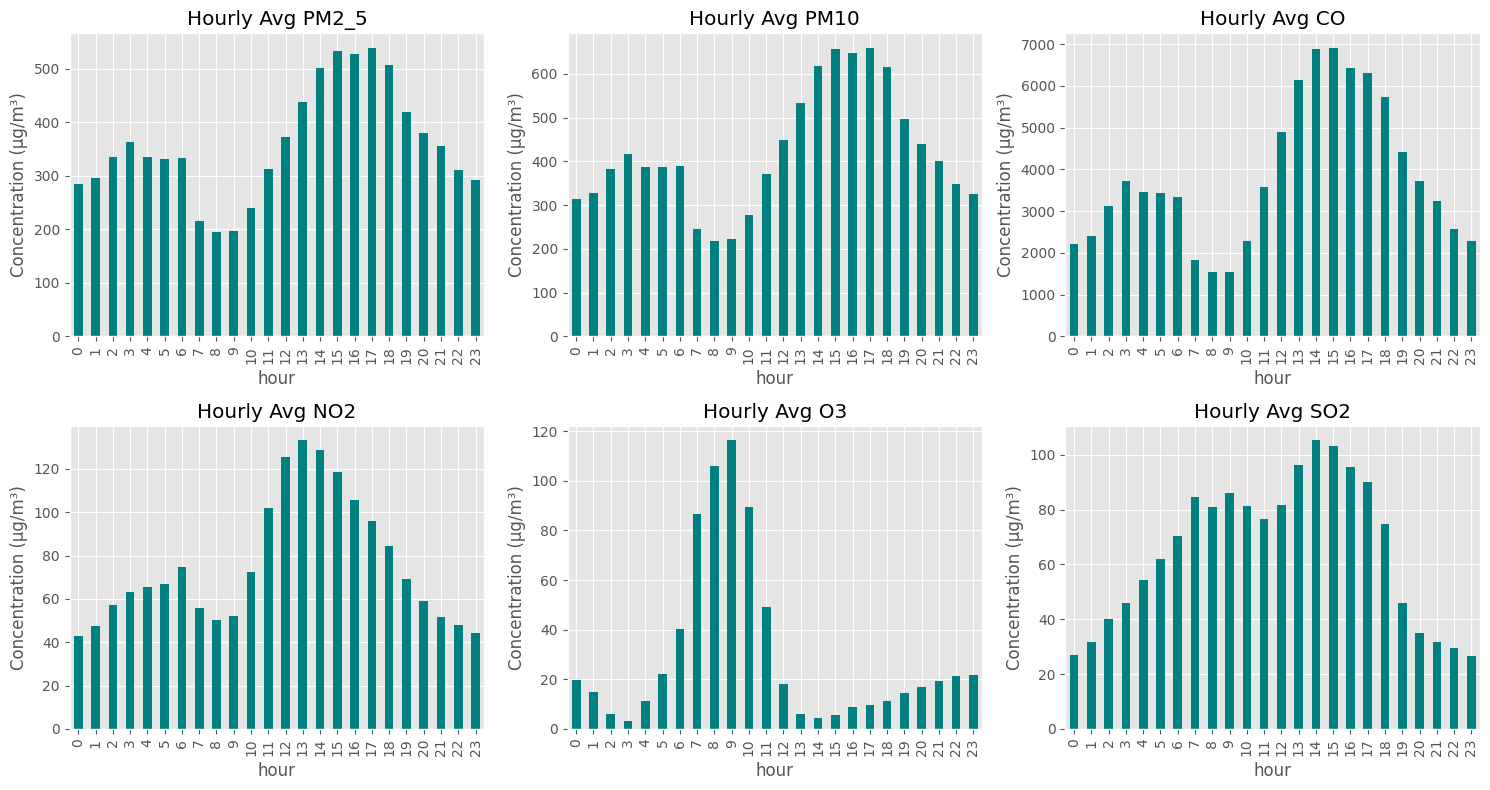

In [3]:
# Plot time series of key pollutants
pollutants = ['pm2_5', 'pm10', 'co', 'no2', 'o3', 'so2']

plt.figure(figsize=(15, 10))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(3, 2, i)
    df[pollutant].plot(title=f'{pollutant.upper()} Over Time')
    plt.ylabel('Concentration (µg/m³)')
plt.tight_layout()
plt.show()

# Plot hourly averages
hourly_avg = df.groupby('hour')[pollutants].mean()

plt.figure(figsize=(15, 8))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)
    hourly_avg[pollutant].plot(kind='bar', color='teal')
    plt.title(f'Hourly Avg {pollutant.upper()}')
    plt.ylabel('Concentration (µg/m³)')
plt.tight_layout()
plt.show()

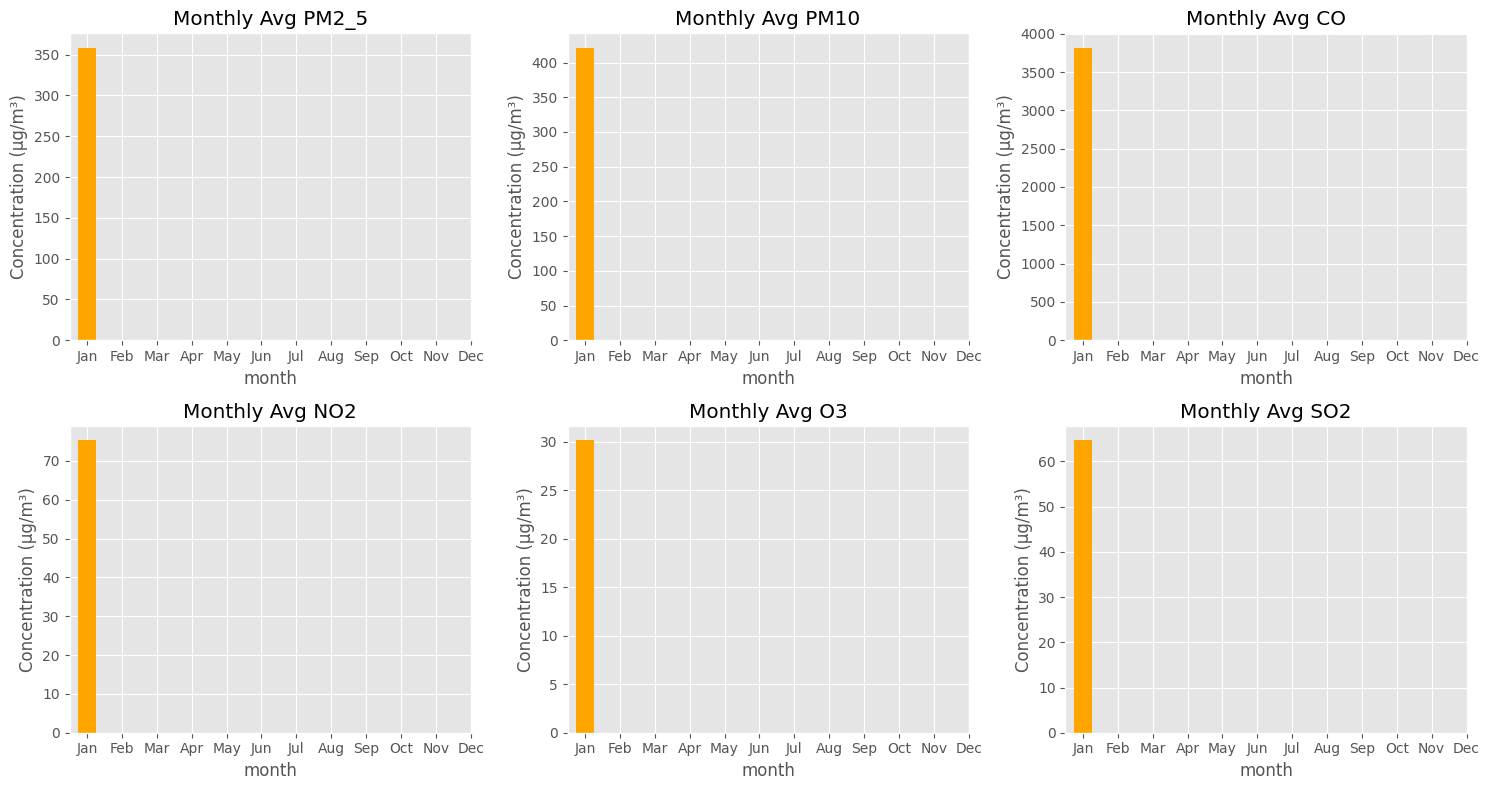

In [8]:
# Monthly averages
monthly_avg = df.groupby('month')[pollutants].mean()

plt.figure(figsize=(15, 8))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)
    monthly_avg[pollutant].plot(kind='bar', color='orange')
    plt.title(f'Monthly Avg {pollutant.upper()}')
    plt.ylabel('Concentration (µg/m³)')
    plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.tight_layout()
plt.show()



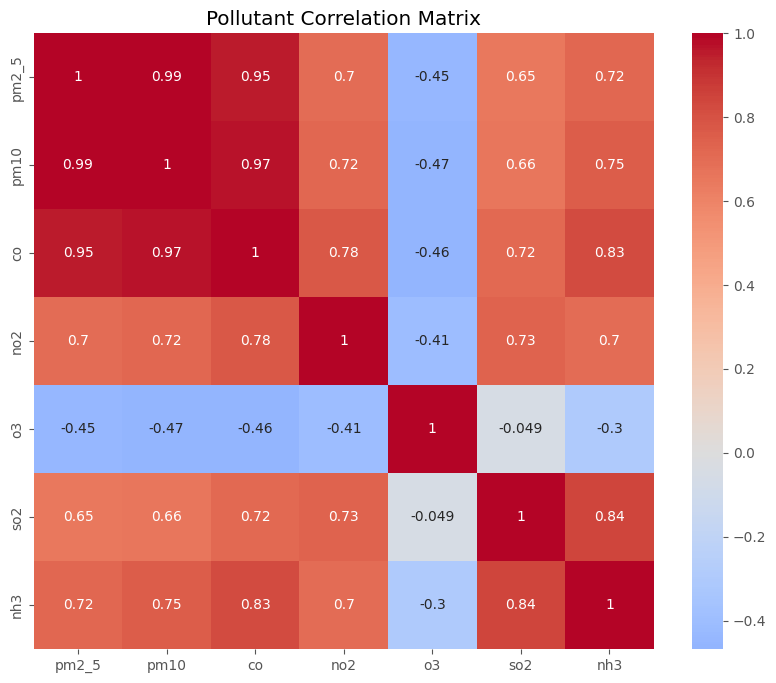

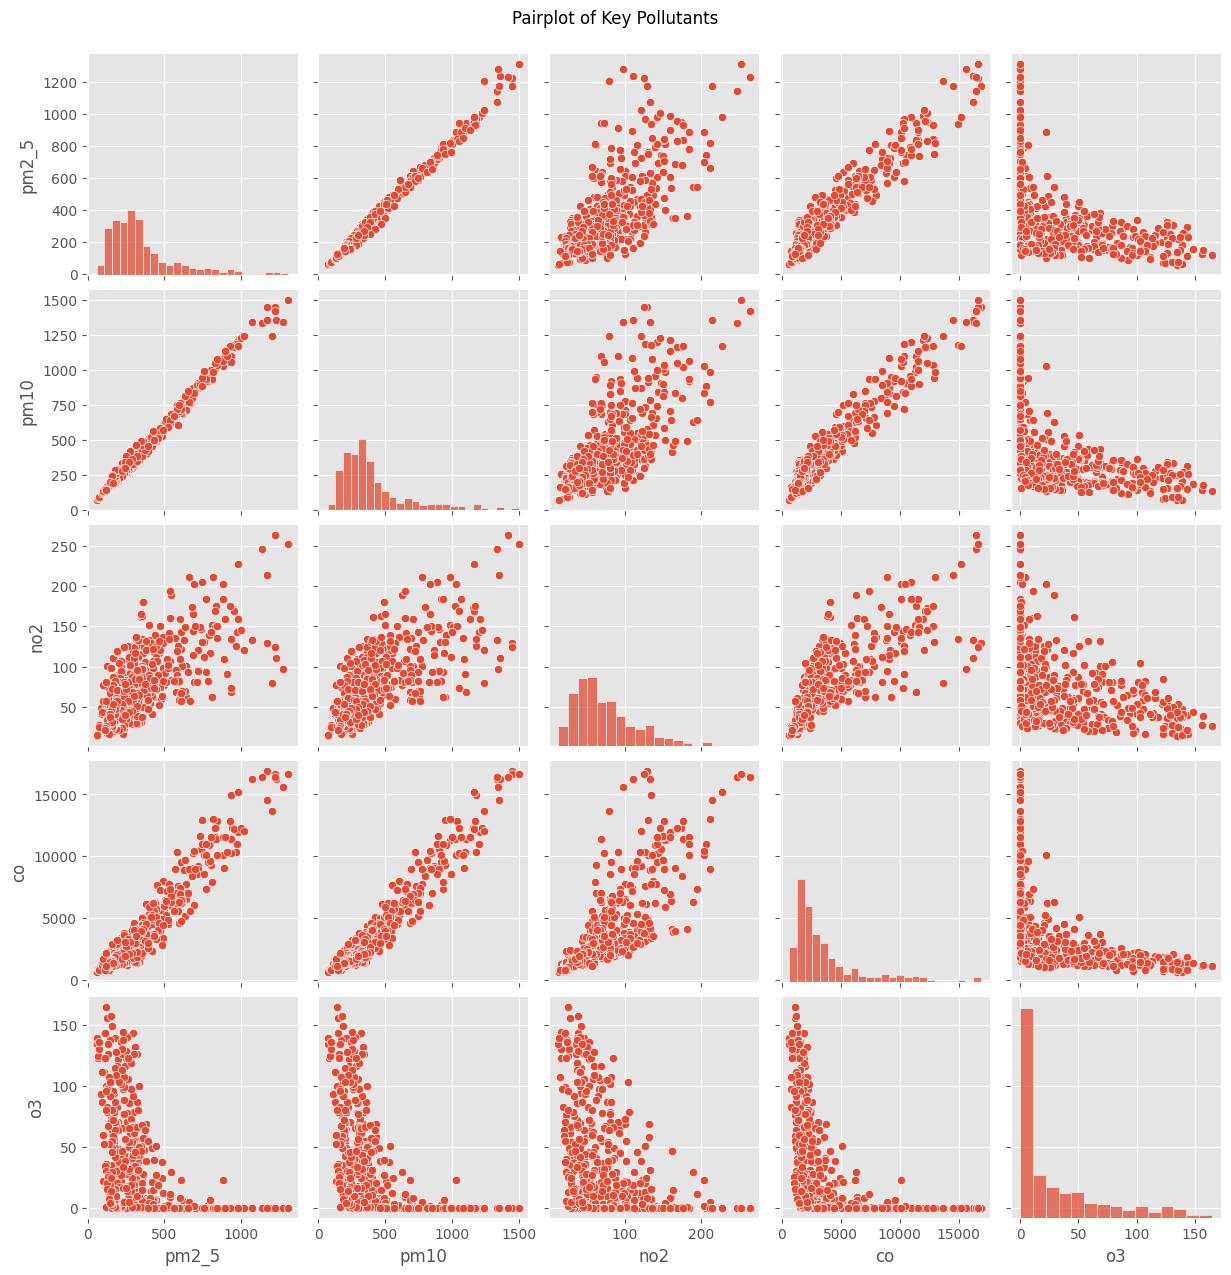

In [9]:
# Correlation matrix
corr_matrix = df[pollutants + ['nh3']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Pollutant Correlation Matrix')
plt.show()

# Pairplot of key pollutants
sns.pairplot(df[['pm2_5', 'pm10', 'no2', 'co', 'o3']])
plt.suptitle('Pairplot of Key Pollutants', y=1.02)
plt.show()

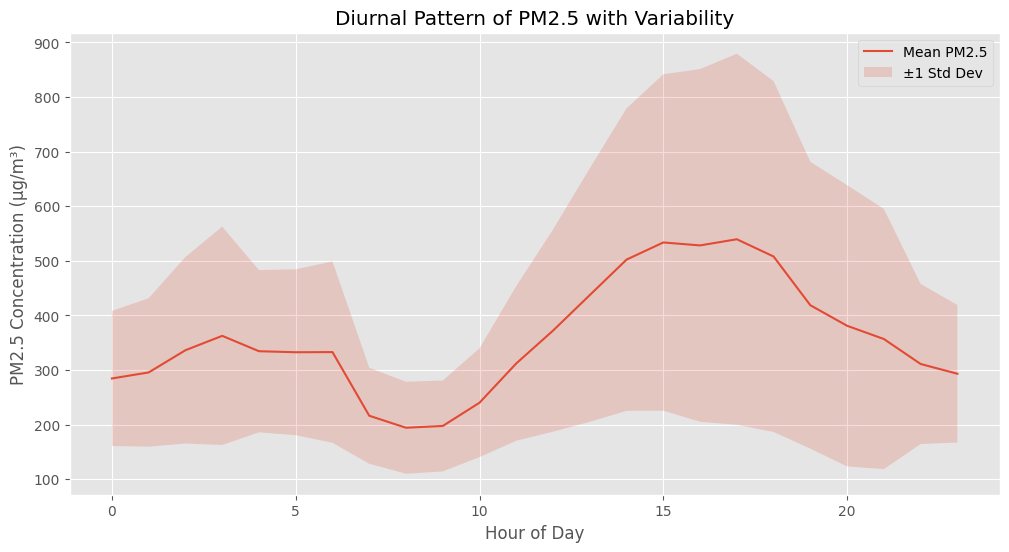

In [10]:
# Diurnal patterns for PM2.5
hourly_pm25 = df.groupby('hour')['pm2_5'].agg(['mean', 'std'])

plt.figure(figsize=(12, 6))
plt.plot(hourly_pm25.index, hourly_pm25['mean'], label='Mean PM2.5')
plt.fill_between(hourly_pm25.index,
                 hourly_pm25['mean'] - hourly_pm25['std'],
                 hourly_pm25['mean'] + hourly_pm25['std'],
                 alpha=0.2, label='±1 Std Dev')
plt.title('Diurnal Pattern of PM2.5 with Variability')
plt.xlabel('Hour of Day')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()

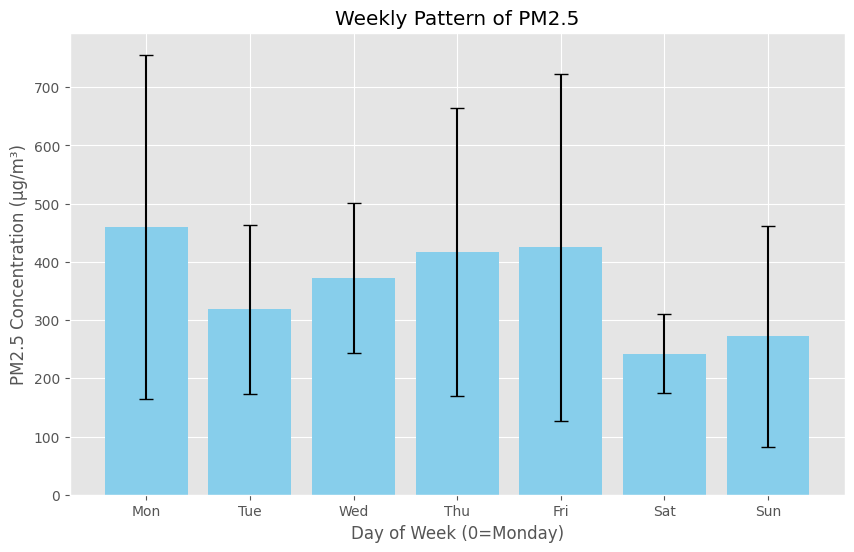

In [11]:
# Weekly patterns
weekday_avg = df.groupby('day_of_week')['pm2_5'].mean()
weekday_std = df.groupby('day_of_week')['pm2_5'].std()

plt.figure(figsize=(10, 6))
plt.bar(weekday_avg.index, weekday_avg, yerr=weekday_std,
        color='skyblue', capsize=5)
plt.title('Weekly Pattern of PM2.5')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.show()

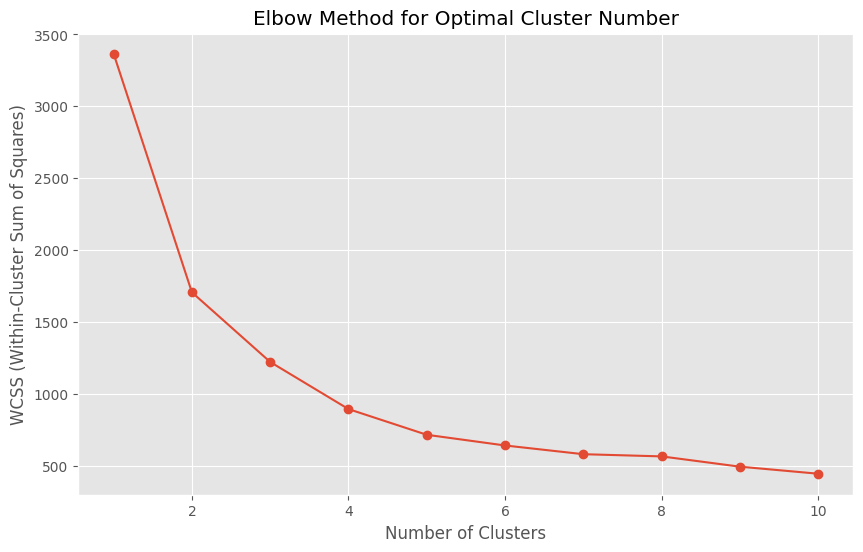

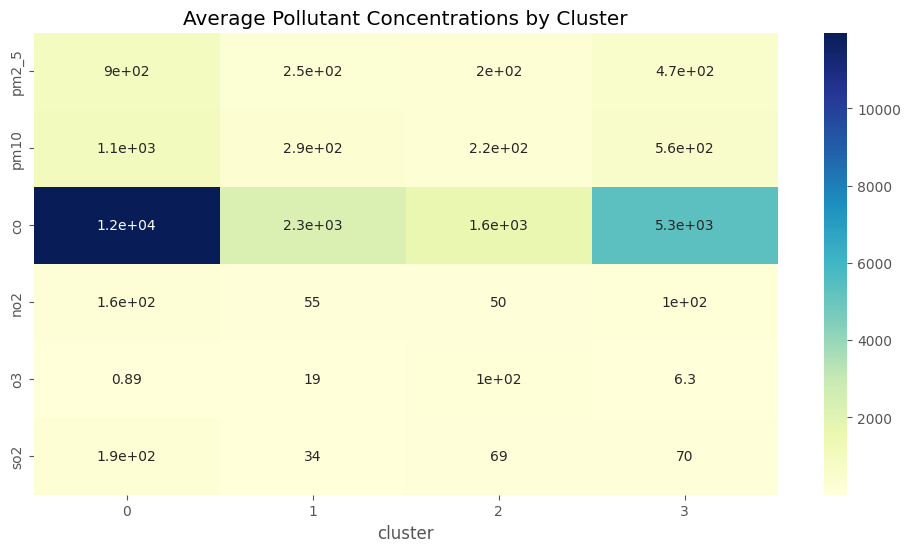

In [12]:
# Standardize data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[pollutants])

# Determine optimal number of clusters using elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_data)

# Analyze cluster characteristics
cluster_means = df.groupby('cluster')[pollutants].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means.T, annot=True, cmap='YlGnBu')
plt.title('Average Pollutant Concentrations by Cluster')
plt.show()


Pollution Episode Statistics:
count     22.000000
mean      16.227273
std       25.457587
min        1.000000
25%        4.250000
50%        9.500000
75%       20.500000
max      125.000000
dtype: float64


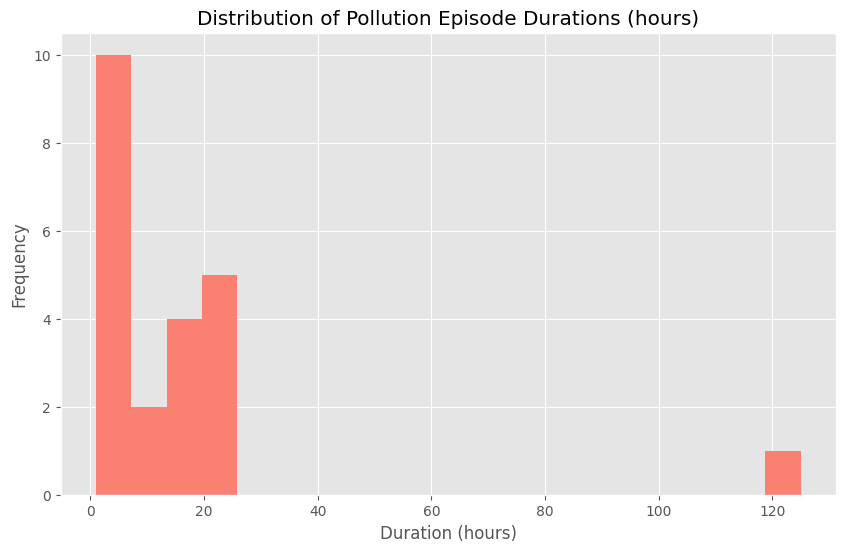

In [13]:
# Identify pollution episodes (PM2.5 > 250 µg/m³)
df['pm25_high'] = (df['pm2_5'] > 250).astype(int)

# Calculate episode duration
df['episode'] = (df['pm25_high'].diff() == 1).cumsum()
episodes = df[df['pm25_high'] == 1].groupby('episode').size()
print("\nPollution Episode Statistics:")
print(episodes.describe())

# Plot episode duration distribution
plt.figure(figsize=(10, 6))
episodes.hist(bins=20, color='salmon')
plt.title('Distribution of Pollution Episode Durations (hours)')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

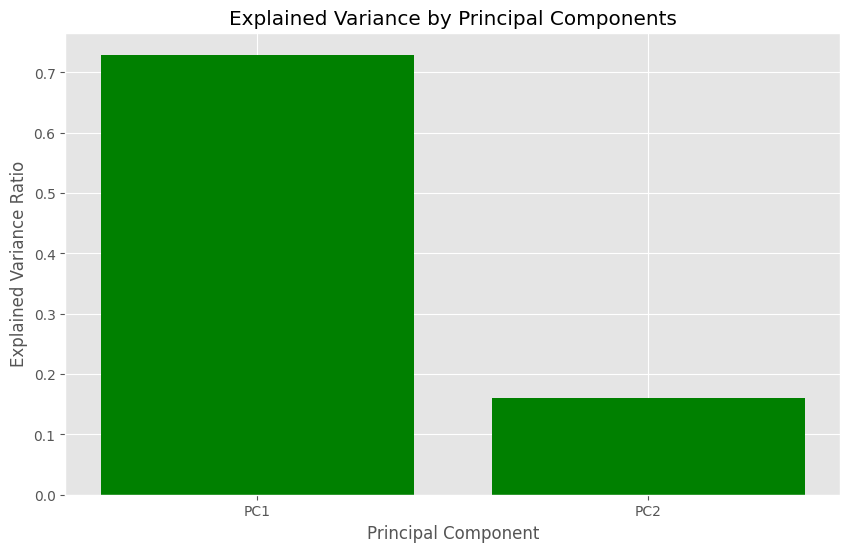

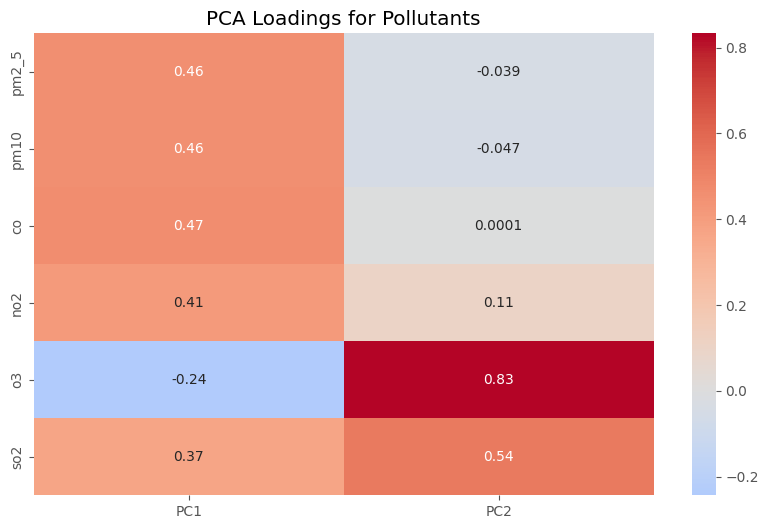

In [17]:
# Principal Component Analysis for source identification
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()
scaled_pollutants = scaler.fit_transform(df[pollutants])

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_pollutants)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components,
                      columns=['PC1', 'PC2'],
                      index=df.index)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_, color='green')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(pca.n_components_), ['PC1', 'PC2'])
plt.grid(True)
plt.show()

# Plot the loadings
loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC1', 'PC2'],
                        index=pollutants)

plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loadings for Pollutants')
plt.show()

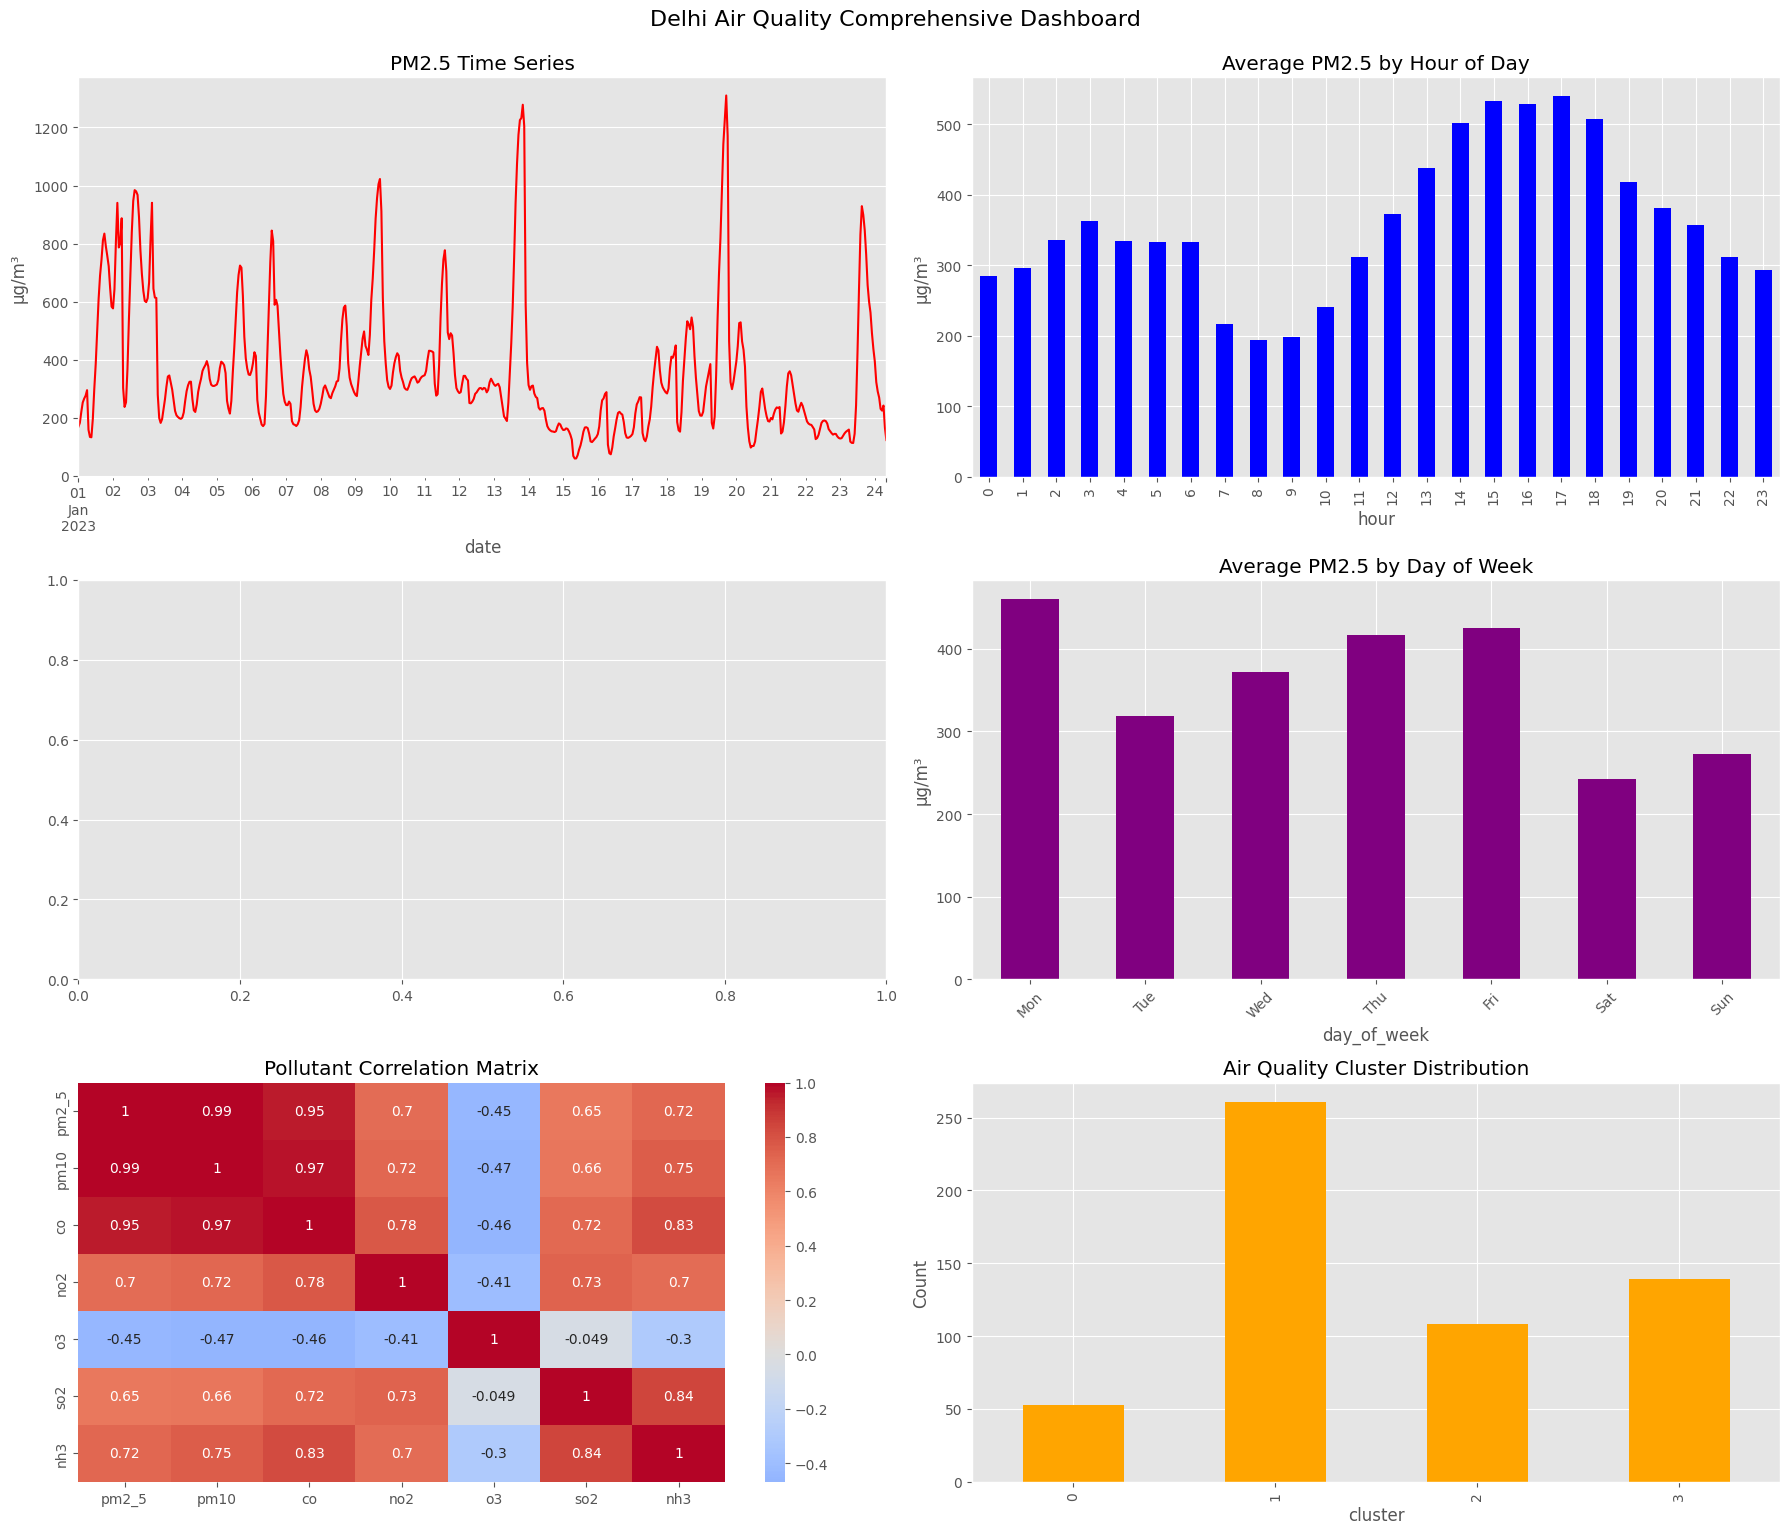

In [28]:
# Create a comprehensive dashboard of key metrics
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# PM2.5 Time Series
df['pm2_5'].plot(ax=axes[0, 0], color='red')
axes[0, 0].set_title('PM2.5 Time Series')
axes[0, 0].set_ylabel('µg/m³')

# Hourly Pattern
hourly_avg['pm2_5'].plot(kind='bar', ax=axes[0, 1], color='blue')
axes[0, 1].set_title('Average PM2.5 by Hour of Day')
axes[0, 1].set_ylabel('µg/m³')

# Weekday Pattern
weekday_avg.plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Average PM2.5 by Day of Week')
axes[1, 1].set_ylabel('µg/m³')
axes[1, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)

# Correlation Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[2, 0])
axes[2, 0].set_title('Pollutant Correlation Matrix')

# Cluster Distribution
df['cluster'].value_counts().sort_index().plot(kind='bar', ax=axes[2, 1], color='orange')
axes[2, 1].set_title('Air Quality Cluster Distribution')
axes[2, 1].set_ylabel('Count')

plt.tight_layout()
plt.suptitle('Delhi Air Quality Comprehensive Dashboard', y=1.02, fontsize=16)
plt.show()

# **Key Findings:-**

**Most Critical Pollutants (by average levels):**

CO (Carbon Monoxide): ~3815 µg/m³

PM10: ~421 µg/m³

PM2.5: ~358 µg/m³
These exceed safe limits and are top contributors to Delhi’s poor air quality.

**Seasonal Variation (Winter dominates pollution):**

All pollutants peak in Winter.

Likely due to low wind speeds, temperature inversion, and higher emissions during the season.

**Hourly Trends:**

Peaks typically observed in morning (7–10 AM) and evening (6–9 PM) hours.

Matches traffic hours, indicating vehicle emissions as a major source.

**Correlations:**

Strong positive correlations between PM2.5, PM10, CO, and NO2.

Suggests common sources like vehicular emissions and industrial activity.

###Recommendations:###
1. Target winter months (Nov-Jan) for intensified pollution control measures
2. Implement stricter regulations on combustion sources (CO and NO2 correlated with PM2.5)
3. Address morning and evening pollution peaks through traffic management
4. Develop cluster-specific intervention strategies based on pollution patterns
5. Enhance monitoring during identified high-pollution periods

###Conclusion:###
The analysis reveals significant seasonal and diurnal patterns in Delhi's air quality,
with winter months showing the worst conditions. The strong correlations between
certain pollutants suggest common sources that could be targeted for intervention.

# Research Questions
**Seasonal Trends:**

How does the AQI and its key pollutants vary across seasons (winter, summer, monsoon)?

**Pollutant Contribution:**

Which pollutants contribute most to poor air quality in Delhi, and how do their levels correlate with each other?

**Temporal Variation:**

What are the daily and hourly patterns of AQI pollutants, and which times of day exhibit the highest concentration levels?